### The purpose of this notebook is to compare and explore different imputation methods - it is not involved in the actual pipeline of the project

In [1]:
import numpy as np
import pandas as pd
import torch

from imputation_utils import *

# Import data

In [2]:
data, VARIABLES = import_data(discard_variables=True, discard_days=True, THRESHOLD=60)

discarded variables: ['GalvanicSkinResponse', 'ActivityClass']
discarded days (less than 60min of data): [312]
discarded days (sensor out all day): [114]


# Imputation

Format data into daily dataframes (for imputation model)

In [3]:
data_daily = data_to_days(data)

100%|██████████| 408/408 [02:02<00:00,  3.34it/s]


Normalize day-variable-wise

In [4]:
normalize_by_day(data_daily)

day 0 - ActivityCounts: mean: 1.2688263138573217e-17, std: 0.9999999999999959
day 0 - Barometer: mean: -5.938107148852266e-14, std: 0.9999999999999997
day 0 - BloodPerfusion: mean: 2.3770417019099194e-16, std: 1.000000000000001
day 0 - BloodPulseWave: mean: 1.092154295472125e-16, std: 1.0000000000000004
day 0 - EnergyExpenditure: mean: -5.075305255429287e-17, std: 1.0000000000000064
day 0 - HR: mean: -9.765144288927236e-16, std: 1.0
day 0 - HRV: mean: 1.5650721051984586e-16, std: 0.9999999999999997
day 0 - RESP: mean: -3.760906729921135e-16, std: 0.9999999999999998
day 0 - Steps: mean: -3.6478756523398e-17, std: 0.9999999999999938
day 0 - SkinTemperature: mean: 2.816794416763254e-15, std: 0.999999999999999
day 1 - ActivityCounts: mean: 0.0, std: 0.9999999999999909
day 1 - Barometer: mean: 7.088903107932162e-14, std: 0.9999999999999981
day 1 - BloodPerfusion: mean: -3.120978341552417e-17, std: 0.9999999999999994
day 1 - BloodPulseWave: mean: 6.241956683104833e-17, std: 0.999999999999999

### Explore imputation methods

In [5]:
# choose day
day = 400
data_day = data_daily[day]

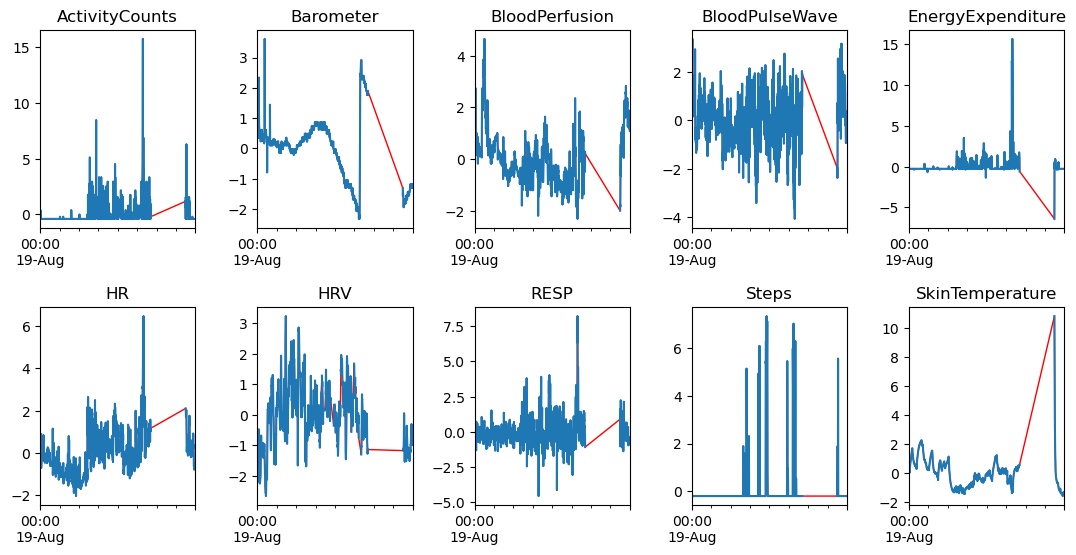

In [6]:
visualize_imputation(data_day, 'linear')

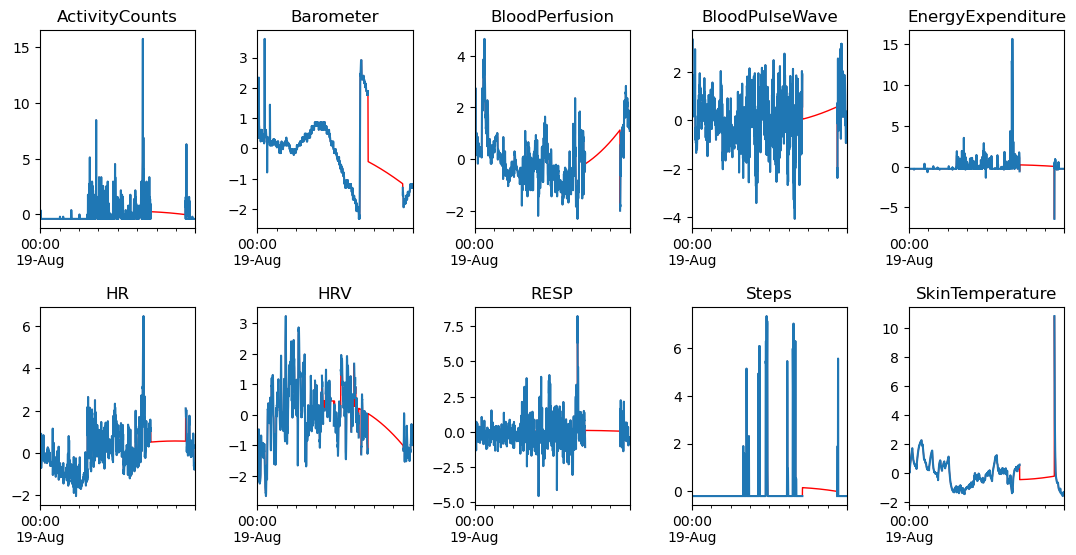

In [7]:
visualize_imputation(data_day, 'spline', order=2)

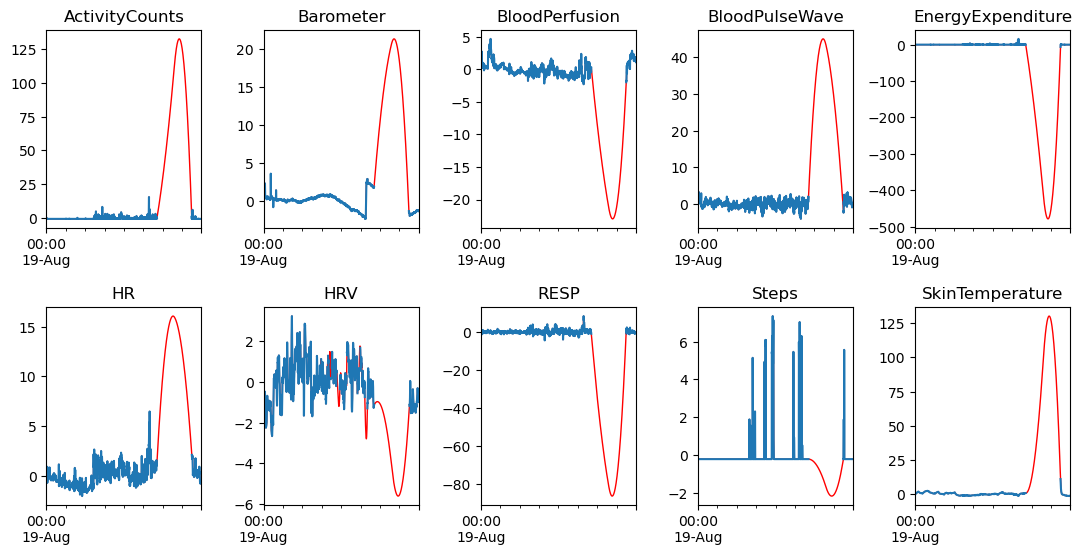

In [8]:
visualize_imputation(data_day, 'quadratic')

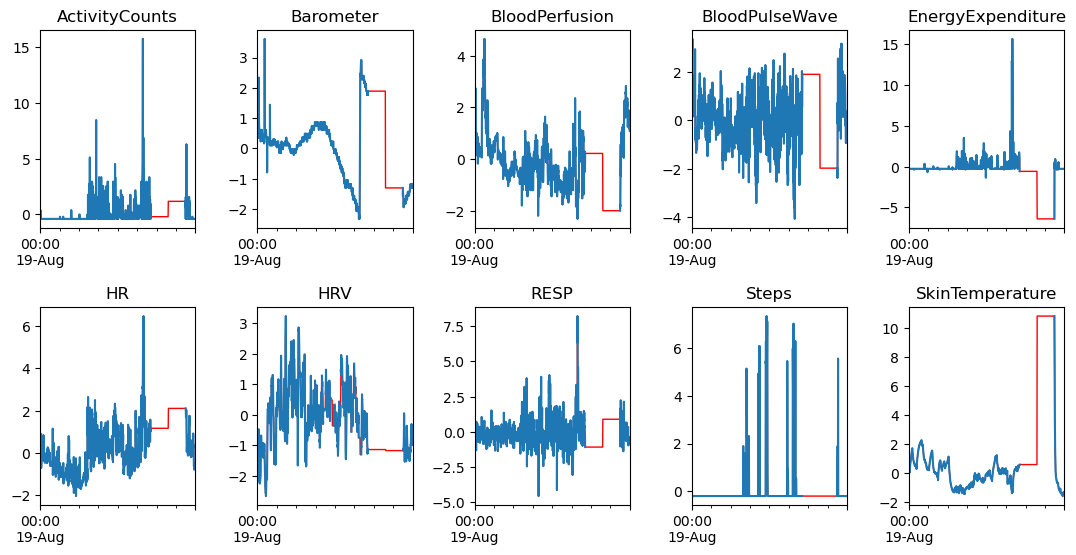

In [9]:
visualize_imputation(data_day, 'nearest')

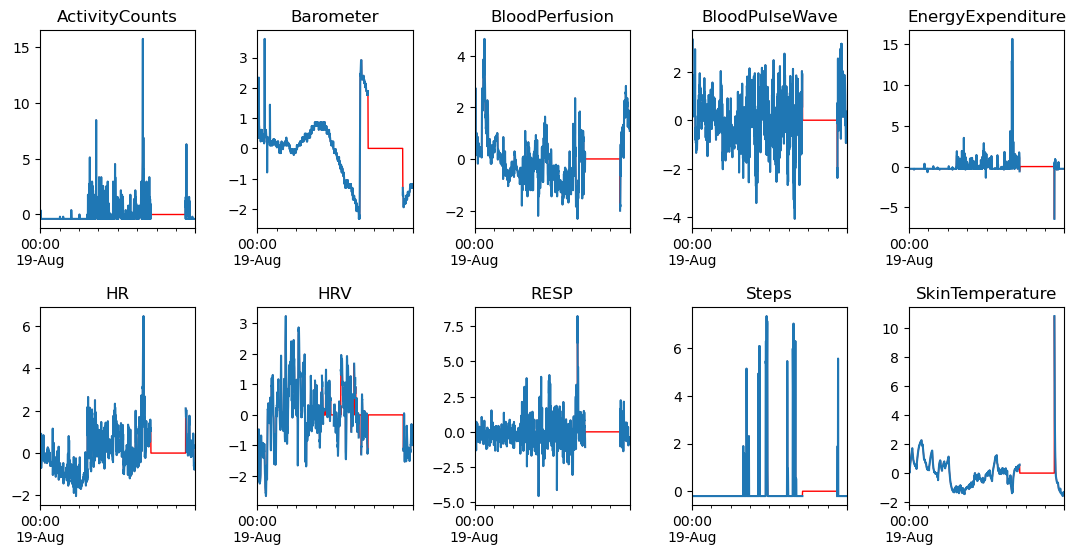

In [10]:
visualize_imputation(data_day, 'mean')

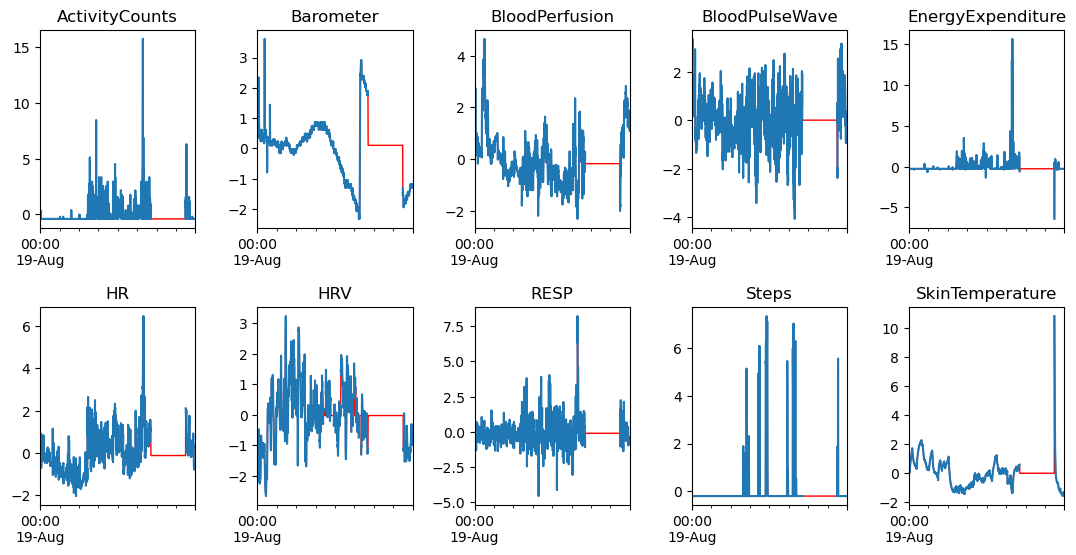

In [11]:
visualize_imputation(data_day, 'median')

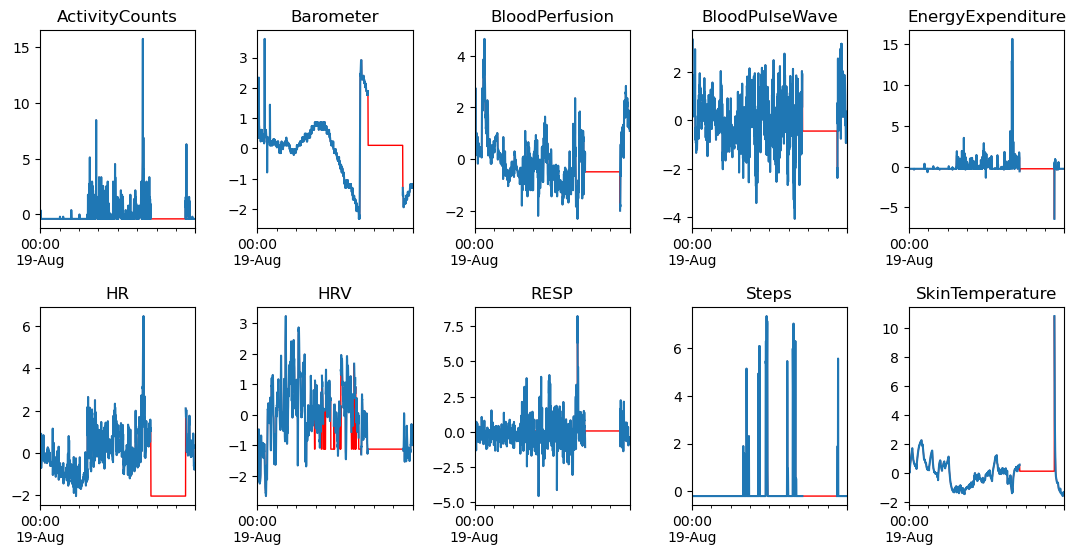

In [12]:
visualize_imputation(data_day, 'mode')

Note: general problem are long missing sequences, e.g.:

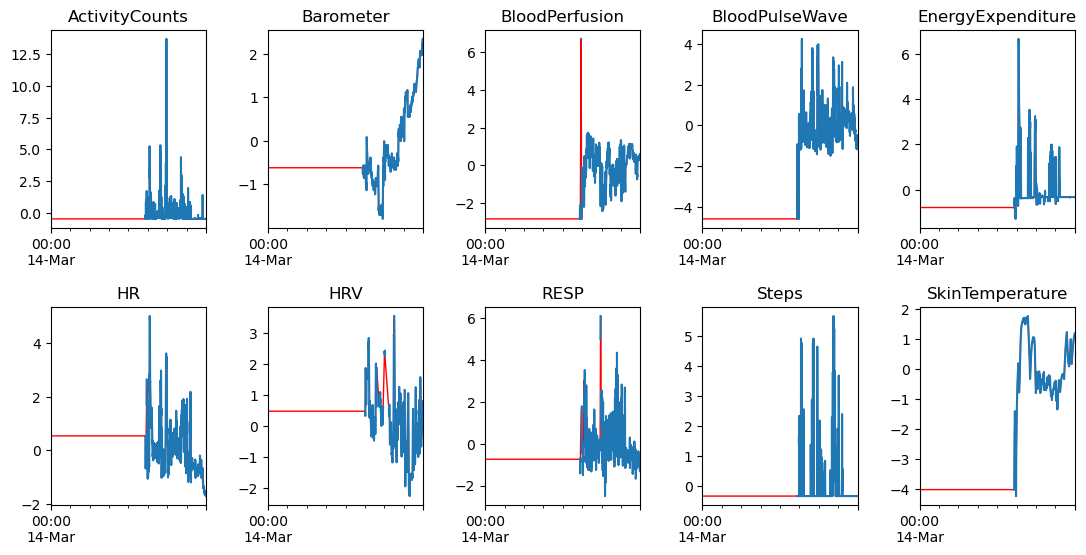

In [13]:
visualize_imputation(data_daily[0], 'linear')

Visualize mask

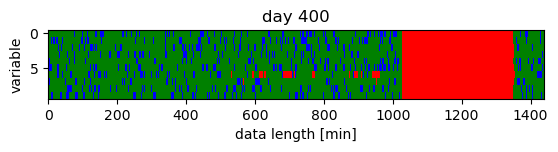

In [7]:
mask = masker(data_day, lm=3, masking_ratio=0.15)
visualize_mask(mask, day)

### Calculate mean sequence length & masking ratio in actual data

Mean sequence length: lm

In [ ]:
na_seqs = na_sequence_lengths(data)

In [ ]:
na_distribution = [[seq_length]*occurence for seq_length, occurence in na_seqs.to_numpy()]
na_distribution = [element for sublist in na_distribution for element in sublist]

In [ ]:
lm = np.mean(na_distribution) # mean masked sequence
lm

Masking ratio: masking_ratio

In [ ]:
# NaN -> 1.0, available data -> NaN
na_flipped = data.copy(deep=True)
n_days, _ = na_flipped.shape
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(na_flipped, variable, day)
        nas = np.isnan(time_series)
        time_series[:] = 1.0 # set full array to 1.0
        time_series[~nas] = np.NaN # set all elements that weren't NaN to NaN

        na_flipped[variable].iloc[day] = time_series

In [ ]:
non_na_seqs = na_sequence_lengths(na_flipped)

In [ ]:
non_na_distribution = [[seq_length]*occurence for seq_length, occurence in non_na_seqs.to_numpy()]
non_na_distribution = [element for sublist in non_na_distribution for element in sublist]

In [51]:
np.mean(non_na_distribution) # mean unmasked sequence

161.50465531381155

In [52]:
r = lm / (np.mean(non_na_distribution) + lm) # masking_ratio
r

0.21195370583292347

Visualize mask

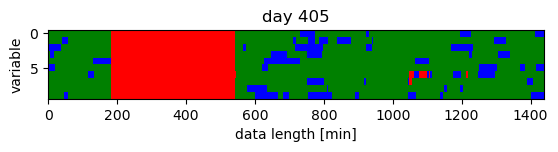

In [53]:
visualize_mask(masker(data_day, lm=lm, masking_ratio=r))

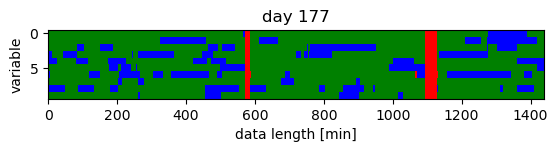

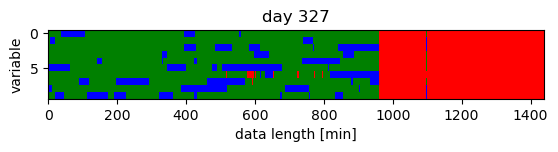

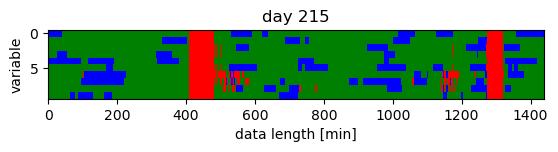

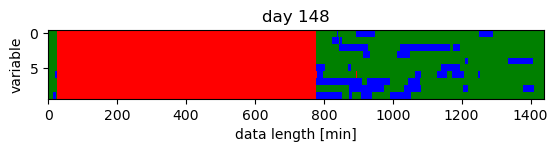

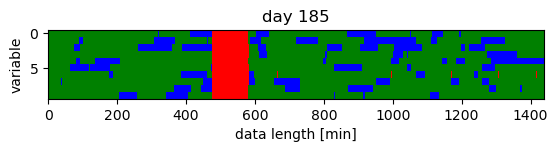

In [54]:
for i in range(5):
    day = np.random.choice(n_days, 1)[0]
    visualize_mask(masker(data_daily[day], lm=lm, masking_ratio=r))

### Scoring of methods

Numerical analysis

In [6]:
# short sequences
test_imputation_methods(data_daily, lm=3, masking_ratio=0.15)

[('linear', (0.2546989900955631, 0.0011065726614260195)),
 ('nearest', (0.2833264315384626, 0.0012309482785236808)),
 ('quadratic', (0.48154310114408166, 0.002092126202873499)),
 ('spline', (0.5730094528959055, 0.002489513582583833)),
 ('median', (0.631549212886187, 0.002743847131324569)),
 ('mean', (0.6781114089124404, 0.0029461426063057583)),
 ('mode', (0.7766532547319903, 0.0033742703839206543))]

In [7]:
# long sequences
test_imputation_methods(data_daily, lm=200, masking_ratio=0.15)

[('mode', (0.5011769114894004, 0.002044109747578171)),
 ('median', (0.5975793669180518, 0.0024372986481732938)),
 ('mean', (0.722937952078029, 0.0029485885739334457)),
 ('linear', (1.7400692283614811, 0.007097079673092157)),
 ('nearest', (1.741428057311821, 0.007102621818867441)),
 ('spline', (2.3304330013765746, 0.009504948661810926)),
 ('quadratic', (6562.385059761181, 26.765469359222255))]

In [57]:
# actual mean of data
test_imputation_methods(data_daily, lm=lm, masking_ratio=r)

[('nearest', (0.5083644934234958, 0.001839382851107746)),
 ('linear', (0.5230483201522551, 0.001892512405635893)),
 ('spline', (0.5432733990534853, 0.001965691519784278)),
 ('median', (0.5602454942578904, 0.0020271005703183095)),
 ('mode', (0.5762568469234104, 0.002085033427347059)),
 ('mean', (0.6300930530372725, 0.0022798255412251737)),
 ('quadratic', (19.49417889525959, 0.0705345452332682))]

In [7]:
'''def plotter_from_array(dat):
    """
    Same as plotter(day, dat) but here dat is array of daily data (shape: [1, 1440, 10])
    """
    if not isinstance(dat, np.ndarray):
        dat = dat.detach().numpy()

    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    batch_size, length, variables = dat.shape
    assert batch_size == 1 and length == 1440 and variables == 10

    # TODO: not sure if correct VARIABLES if we discard in import
    for i, variable in enumerate(VARIABLES):
        time_series = dat[:, :, i].reshape(-1)

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series)
        plt.xlim([0, length])'''

In [ ]:
'''# TODO: for now use batch_size = 1
# TODO: use dataloader?
# TODO: on GPU?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

history = {'train_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0

    # batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        batch = data_daily[batch_index].copy()

        # create mask (on-the-fly) # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
        mask = masker(batch, lm=43, masking_ratio=0.21)

        # reshape
        mask = mask.transpose()
        batch = batch.transpose().to_numpy() # pandas -> numpy + reshape

        # mask missing data
        y_true = torch.tensor(batch).unsqueeze(0).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).unsqueeze(0).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(1, 1440).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss)

    # print
    print(f'Epochs {epoch + 1}/{epochs} - loss: {epoch_loss}')'''

# Transformer imputation

### Model

In [2]:
sequence_length = 48 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
model = TSTransformerEncoder(feat_dim=len(VARIABLES),
                             max_len=sequence_length,
                             d_model=d_model,
                             n_heads=n_heads,
                             num_layers=n_encoder_layers,
                             dim_feedforward=d_model,
                             dropout=0.1,
                             pos_encoding='fixed',
                             activation='gelu',
                             norm='BatchNorm',
                             freeze=False)

model = model.to(device)

In [8]:
# OPTIONAL: load model
'''model = torch.load('./Models/transformer_imputation')'''

"model = torch.load('./Models/transformer_imputation')"

In [9]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [10]:
sum(p.numel() for p in model.parameters()) # TODO: less params (?) (or pruning afterwards?)

5434

### Data

In [11]:
# train-test split (TODO: + val?)
from sklearn.model_selection import train_test_split

n_days = len(data_daily)
train_indices, test_indices = train_test_split(np.arange(n_days), random_state=42)

### Training

In [12]:
# mask on-the-fly? -> model sees more data

In [13]:
epochs = 6500

criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
%%time
# segment day into sequences and treat as batches
model.train() # set model into training mode

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in tqdm(range(epochs)):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    for i, batch_index in enumerate(train_indices):
        # load training batch
        full_day = data_daily[batch_index].copy()

        # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
        mask = masker(full_day, lm=lm, masking_ratio=r)

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        optimizer.zero_grad()
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    with torch.no_grad():
        for i, batch_index in enumerate(test_indices):
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=43, masking_ratio=0.21)

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

            # mask missing data
            y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
            batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
            X = batch

            # predict
            y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

            # update model
            mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            #mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_true, mask=mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / len(train_indices))
        history['test_loss'].append(epoch_loss_test / len(test_indices))

    # print
    #print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss / len(train_indices)}, test loss: {epoch_loss_test / len(test_indices)}')

Starting training for 6500 epochs


100%|██████████| 6500/6500 [26:31:09<00:00, 14.69s/it]   

CPU times: total: 1d 2h 30min 3s
Wall time: 1d 2h 31min 9s


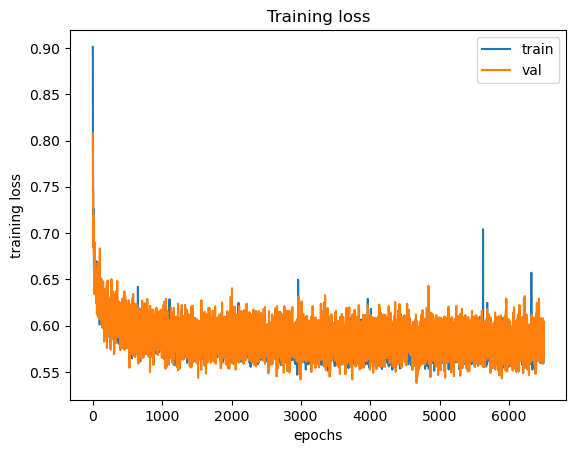

In [15]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

### Evaluation

### a) Visual inspection

In [16]:
day = np.random.choice(test_indices, 1)[0]
day

85

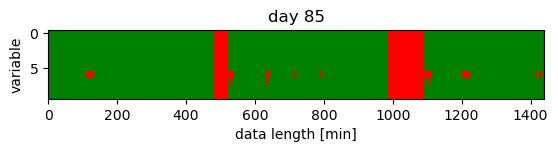

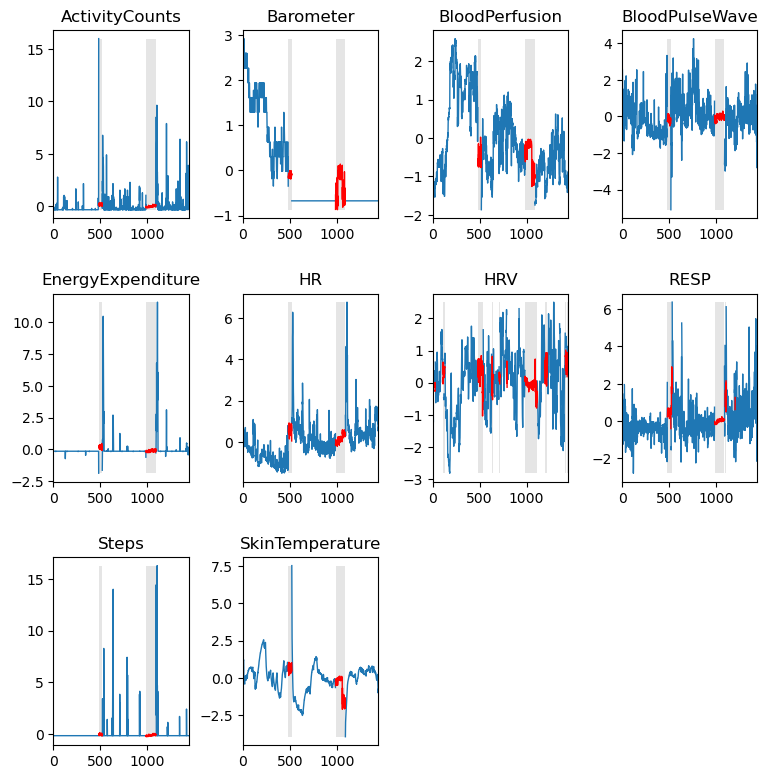

In [17]:
show_prediction(model, data_daily, day, lm=lm, r=r,
                show_mask=True, show_mask_plot=True,
                prediction_only=False, full_prediction=False,
                device=device)

### b) Test set

In [18]:
len(test_indices)

102

In [19]:
test_data = [data_daily[i] for i in test_indices]

evaluate n times

In [325]:
def test_imputation_methods(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {}
    for imputation_method in imputation_methods:
        imputation_errors = np.array([])
        reals = np.array([]) # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            real_data = data_day.to_numpy()[mask == 1.0]
            imputed_data = data_imputed.to_numpy()[mask == 1.0]

            # save
            imputation_errors = np.concatenate((imputation_errors,
                                                np.abs(real_data - imputed_data)),
                                               axis=None)
            reals = np.concatenate((reals, real_data), axis=None)

        mae = np.mean(imputation_errors) # MAE
        mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
        mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
        mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
        mre = np.mean(mre)
        scores[imputation_method] = (mae, mre)

    return sorted(scores.items(), key=lambda x: x[1][0]) # sort by MAE

In [326]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods(test_data,
                                   lm=lm,
                                   masking_ratio=r,
                                   model=model,
                                   device=device)
    except ValueError:
        continue
    if np.any(np.isnan(np.array([element[1] for element in temp]))):
       pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\239718275.py:43: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\239718275.py:43: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_1418

In [327]:
scores

[[('transformer', (0.49551275759549973, 2.3168163690736745)),
  ('linear', (0.5024906938264201, 3.704511542004781)),
  ('nearest', (0.5394236504969303, 4.174307051806322)),
  ('spline', (0.6397316870197255, 3.168613614873971)),
  ('median', (0.6634444747177402, 1.8075667806718687)),
  ('mean', (0.7256474921139784, 1.3413923753863466)),
  ('mode', (0.951905421799911, 6.801794016133733)),
  ('quadratic', (136.588755638993, 403.81018996190534))],
 [('transformer', (0.49452445733227035, 2.867593401340169)),
  ('linear', (0.5106656784600767, 4.7150523576581405)),
  ('nearest', (0.5480890287864707, 5.435634320441747)),
  ('spline', (0.6525472760369463, 3.734790190822051)),
  ('median', (0.6660025765870639, 1.9748785069891188)),
  ('mean', (0.7249034258683053, 1.4755582410446442)),
  ('mode', (0.941966450692299, 7.45957637045453)),
  ('quadratic', (253.29198935238543, 1000.9830848040556))],
 [('transformer', (0.49705085723271586, 2.6084253151938737)),
  ('linear', (0.5070345961091006, 4.09463

In [328]:
t = {'transformer': {'mae': [], 'mre': []},
     'linear': {'mae': [], 'mre': []},
     'nearest': {'mae': [], 'mre': []},
     'spline': {'mae': [], 'mre': []},
     'median': {'mae': [], 'mre': []},
     'mean': {'mae': [], 'mre': []},
     'mode': {'mae': [], 'mre': []},
     'quadratic': {'mae': [], 'mre': []}}
for round in scores:
    for evaluation in round:
        method, (mae, mre) = evaluation
        t[method]['mae'].append(mae)
        t[method]['mre'].append(mre)

In [329]:
scores_mae = pd.DataFrame.from_dict({key: value['mae'] for key, value in t.items()})
scores_mae

,transformer,linear,nearest,spline,median,mean,mode,quadratic
0,0.495513,0.502491,0.539424,0.639732,0.663444,0.725647,0.951905,136.588756
1,0.494524,0.510666,0.548089,0.652547,0.666003,0.724903,0.941966,253.291989
2,0.497051,0.507035,0.542808,0.658794,0.680581,0.736461,0.949833,205.396043
3,0.500545,0.526240,0.563370,0.658462,0.672789,0.733811,0.953901,139.259169
4,0.501020,0.517051,0.551462,0.674156,0.682617,0.737415,0.973938,527.521732
...,...,...,...,...,...,...,...,...
95,0.499224,0.508174,0.544669,0.648948,0.665937,0.726147,0.951560,149.240668
96,0.499041,0.518988,0.555258,0.700933,0.663870,0.722492,0.943312,79.261216
97,0.494862,0.514480,0.550057,0.650938,0.670121,0.725414,0.953322,359.077756
98,0.505838,0.525576,0.562312,0.653432,0.681566,0.739396,0.937483,143.139652


In [330]:
scores_mre = pd.DataFrame.from_dict({key: value['mre'] for key, value in t.items()})
scores_mre

,transformer,linear,nearest,spline,median,mean,mode,quadratic
0,2.316816,3.704512,4.174307,3.168614,1.807567,1.341392,6.801794,403.810190
1,2.867593,4.715052,5.435634,3.734790,1.974879,1.475558,7.459576,1000.983085
2,2.608425,4.094639,4.462824,3.554560,1.971073,1.443554,6.053249,716.075073
3,2.754276,3.928314,4.972142,3.406660,1.816707,1.493309,5.749599,775.184165
4,2.414734,3.458920,3.778900,3.611879,2.007245,1.412339,7.881441,2068.621425
...,...,...,...,...,...,...,...,...
95,2.469801,4.499228,4.896377,3.699887,1.994296,1.497945,6.978341,692.787489
96,2.863085,4.470967,5.115541,4.235336,2.240849,1.366285,6.052811,387.689640
97,3.019188,4.144540,4.721747,3.516080,2.518674,1.495622,6.865268,1982.950070
98,2.895294,4.461656,5.348533,3.484083,2.243141,1.644516,9.177496,667.442601


save scores (optional)

In [331]:
#with open(f'scores_mae{epochs}.txt','w') as dat:
    #dat.write(str(scores_mae))
#with open(f'scores_mre{epochs}.txt','w') as dat:
    #dat.write(str(scores_mre))

to Latex

In [332]:
# 1) MAE
# calculate mean, std
mae = scores_mae.mean().rename('MAE')
mae.index = [word.capitalize() for word in mae.index] # capitalize method names
mae_std = scores_mae.std()

# combine in each entry
n_rows = mae.shape[0]
for i in range(n_rows):
    mae.iloc[i] = str(np.round(mae.iloc[i], 4)) + ' ± ' + str(np.round(mae_std.iloc[i], 4))

# make smallest bold
index_max = np.argmin([float(entry.split('±')[0]) for entry in mae])
entry = mae.iloc[index_max]
entry = 'BOLD{' + entry + '}'
mae.iloc[index_max] = entry

# 2) MRE
# calculate mean, std
mre = scores_mre.mean().rename('MRE')
mre.index = [word.capitalize() for word in mre.index] # capitalize method names
mre_std = scores_mre.std()

# combine in each entry
n_rows = mre.shape[0]
for i in range(n_rows):
    mre.iloc[i] = str(np.round(mre.iloc[i], 4)) + ' ± ' + str(np.round(mre_std.iloc[i], 4))

# make smallest bold
index_max = np.argmin([float(entry.split('±')[0]) for entry in mre])
entry = mre.iloc[index_max]
entry = 'BOLD{' + entry + '}'
mre.iloc[index_max] = entry

# combine
df = pd.DataFrame([mae, mre]).transpose()

# sort by MAE
df.insert(1, 'temp', scores_mae.mean().to_numpy())
df = df.sort_values(by=['temp'])
df = df.drop(['temp'], axis=1)

# to latex
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption=f'Imputation metrics (n=100) ({epochs} epochs)',
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
)

\begin{table}[H]
\centering
\caption{Imputation metrics (n=100) (6500 epochs)}
\begin{tabular}{lll}
\toprule
{} &                    MAE &                   MRE \\
\midrule
\textbf{Transformer} &  \textbf{0.4959 ± 0.0049} &       2.8997 ± 0.6633 \\
\textbf{Linear     } &        0.5123 ± 0.0085 &       4.3612 ± 0.9927 \\
\textbf{Nearest    } &        0.5486 ± 0.0091 &       4.9244 ± 1.1862 \\
\textbf{Median     } &        0.6694 ± 0.0071 &        2.1786 ± 0.331 \\
\textbf{Spline     } &         0.6804 ± 0.061 &       3.9025 ± 0.7661 \\
\textbf{Mean       } &        0.7294 ± 0.0051 &  \textbf{1.498 ± 0.1323} \\
\textbf{Mode       } &        0.9531 ± 0.0177 &       7.6318 ± 1.5446 \\
\textbf{Quadratic  } &     189.3845 ± 94.6789 &   964.7324 ± 795.0924 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2611795880.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Save model

In [20]:
torch.save(model, f'./Models/transformer_imputation{epochs}')

### Save data

In [336]:
np.save(f'./Models/training_data{epochs}', [data_daily[i] for i in train_indices])
np.save(f'./Models/test_data{epochs}', test_data)

### Analyse large/small sequences

In [317]:
def test_imputation_methods_by_sequence(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {'small': None, 'medium': None, 'long': None} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        imputation_errors = []
        reals = [] # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            for i, _ in enumerate(VARIABLES):
                mask_variable = mask[i, :] # mask for current variable
                imputed_variable = data_imputed.to_numpy()[i, :] # imputed data for current variable
                masked_elements = np.where(mask_variable == 1.0)[0] # boolean array, noting where data is imputed (imputed: 1.0)
                sequence_indices = np.split(masked_elements, np.where(np.diff(masked_elements) > 1)[0]) # indices for continuous imputation sequences
                for sequence in sequence_indices:
                    real = data_day.to_numpy()[i, :][sequence]
                    error = imputed_variable[sequence] - real

                    imputation_errors.append(error)
                    reals.append(real)

        sequence_lengths = [len(seq) for seq in imputation_errors]

        # we define long sequences as > 75th percentile, small sequences as < 25th percentile, medium sequences between 25th, 75th percentile
        long_sequence_threshold = np.percentile(sequence_lengths, 75)
        small_sequence_threshold = np.percentile(sequence_lengths, 25)

        long_sequences_selection = sequence_lengths > long_sequence_threshold # boolean masks
        small_sequences_selection = sequence_lengths < small_sequence_threshold # boolean masks
        medium_sequences_selection = (small_sequence_threshold < sequence_lengths) & (sequence_lengths < long_sequence_threshold) # boolean masks

        for name, selection in zip(('small', 'medium', 'long'), (small_sequences_selection, medium_sequences_selection, long_sequences_selection)):
            errors = np.concatenate(np.array(imputation_errors)[selection])
            real_data = np.concatenate(np.array(reals)[selection])

            mae = np.mean(np.abs(errors))
            mre = np.divide(np.abs(errors), np.abs(real_data))
            mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
            mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
            mre = np.mean(mre)

            scores[imputation_method][name] = (mae, mre)

    return scores

In [318]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_sequence(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][sequence]) for method in temp.keys() for sequence in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  errors = np.concatenate(np.array(imputation_errors)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  real_data = np.concatenate(np.array(reals)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:60: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Te

In [319]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    table = {}
    for sequence in ('small', 'medium', 'long'):
        mae_mean = np.round(np.mean([score[imputation_method][sequence][0] for score in scores]), ROUNDING)
        mae_std = np.round(np.std([score[imputation_method][sequence][0] for score in scores]), ROUNDING)

        mre_mean = np.round(np.mean([score[imputation_method][sequence][1] for score in scores]), ROUNDING)
        mre_std = np.round(np.std([score[imputation_method][sequence][1] for score in scores]), ROUNDING)

        table[sequence] = (str(mae_mean) + ' ± ' + str(mae_std),
                           str(mre_mean) + ' ± ' + str(mre_std))

    table = pd.DataFrame.from_dict(table).transpose()
    table.columns = ['MAE', 'MRE']
    table.index = ['Small sequences', 'Medium sequences', 'Long sequences']

    # make smallest bold
    for col in (0, 1):
        index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [320]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by sequence length (n=100) ({epochs} epochs)' if imputation_method == 'transformer' else '-imputation by sequence length (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by sequence length (n=100)}
\begin{tabular}{lll}
\toprule
{} &                 MAE &                  MRE \\
\midrule
\textbf{Small sequences } &  \textbf{0.72 ± 0.008} &  \textbf{1.376 ± 0.869} \\
\textbf{Medium sequences} &       0.736 ± 0.007 &        1.479 ± 0.315 \\
\textbf{Long sequences  } &        0.72 ± 0.008 &        1.611 ± 0.298 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by sequence length (n=100)}
\begin{tabular}{lll}
\toprule
{} &                  MAE &                  MRE \\
\midrule
\textbf{Small sequences } &  \textbf{0.657 ± 0.011} &  \textbf{1.755 ± 0.815} \\
\textbf{Medium sequences} &        0.679 ± 0.009 &        2.154 ± 0.698 \\
\textbf{Long sequences  } &        0.657 ± 0.011 &        2.295 ± 0.444 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Mode}-imputation by sequence length (n=100)}
\begin{tab

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2093705905.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Analyse variable-wise

In [321]:
def test_imputation_methods_by_variable(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {variable: None for variable in VARIABLES} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        imputation_errors = {variable: [] for variable in VARIABLES}
        reals = {variable: [] for variable in VARIABLES} # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            errors = {variable: data_imputed.to_numpy()[i, :][mask[i, :] == 1.0] - data_day.to_numpy()[i, :][mask[i, :] == 1.0]
                      for i, variable in enumerate(VARIABLES)}
            real_data = {variable: data_day.to_numpy()[i, :][mask[i, :] == 1.0] for i, variable in enumerate(VARIABLES)}
            for variable, value in imputation_errors.items():
                imputation_errors[variable] = np.append(value, errors[variable])
            for variable, value in reals.items():
                reals[variable] = np.append(value, real_data[variable])

        for variable in VARIABLES:
            errors = imputation_errors[variable]
            real_data = reals[variable]
            mae = np.mean(np.abs(errors))
            mre = np.divide(np.abs(errors), np.abs(real_data))
            mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
            mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
            mre = np.mean(mre)

            scores[imputation_method][variable] = (mae, mre)

    return scores

In [322]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_variable(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][variable]) for method in temp.keys() for variable in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountere

In [323]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    table = {}
    for variable in VARIABLES:
        mae_mean = np.round(np.mean([score[imputation_method][variable][0] for score in scores]), ROUNDING)
        mae_std = np.round(np.std([score[imputation_method][variable][0] for score in scores]), ROUNDING)

        mre_mean = np.round(np.mean([score[imputation_method][variable][1] for score in scores]), ROUNDING)
        mre_std = np.round(np.std([score[imputation_method][variable][1] for score in scores]), ROUNDING)

        table[variable] = (str(mae_mean) + ' ± ' + str(mae_std),
                           str(mre_mean) + ' ± ' + str(mre_std))

    table = pd.DataFrame.from_dict(table).transpose()
    table.columns = ['MAE', 'MRE']
    tables.append(table)

In [324]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by variable (n=100) ({epochs} epochs)' if imputation_method == 'transformer' else '-imputation by variable (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by variable (n=100)}
\begin{tabular}{lll}
\toprule
{} &            MAE &            MRE \\
\midrule
\textbf{ActivityCounts   } &  0.568 ± 0.011 &  1.138 ± 0.054 \\
\textbf{Barometer        } &   0.864 ± 0.02 &   1.363 ± 0.18 \\
\textbf{BloodPerfusion   } &  0.842 ± 0.017 &  1.341 ± 0.108 \\
\textbf{BloodPulseWave   } &   0.76 ± 0.015 &  1.547 ± 0.306 \\
\textbf{EnergyExpenditure} &  0.608 ± 0.016 &  1.154 ± 0.113 \\
\textbf{HR               } &  0.805 ± 0.018 &   1.856 ± 0.53 \\
\textbf{HRV              } &  0.818 ± 0.016 &  2.716 ± 2.082 \\
\textbf{RESP             } &  0.757 ± 0.012 &  1.541 ± 0.222 \\
\textbf{Steps            } &  0.469 ± 0.015 &   1.039 ± 0.03 \\
\textbf{SkinTemperature  } &  0.819 ± 0.018 &  1.933 ± 0.547 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by variable (n=100)}
\begin{tabular}{lll}
\toprule
{} &            MAE &            MRE \\
\mid

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\436902079.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Additional metrics

Load model

In [16]:
sequence_length = 48 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
model = torch.load('Models/imputation_comparison/transformer_imputation6500')

In [18]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [19]:
test_data = np.load('Models/imputation_comparison/test_data6500.npy')

In [20]:
test_data.shape

(102, 10, 1440)

Check if model correct (trained)

In [21]:
show_mask=True
show_mask_plot=True
prediction_only=False
full_prediction=False

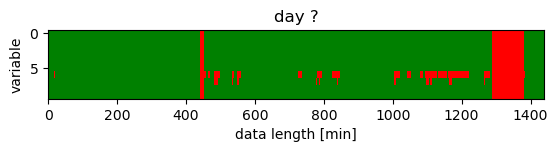

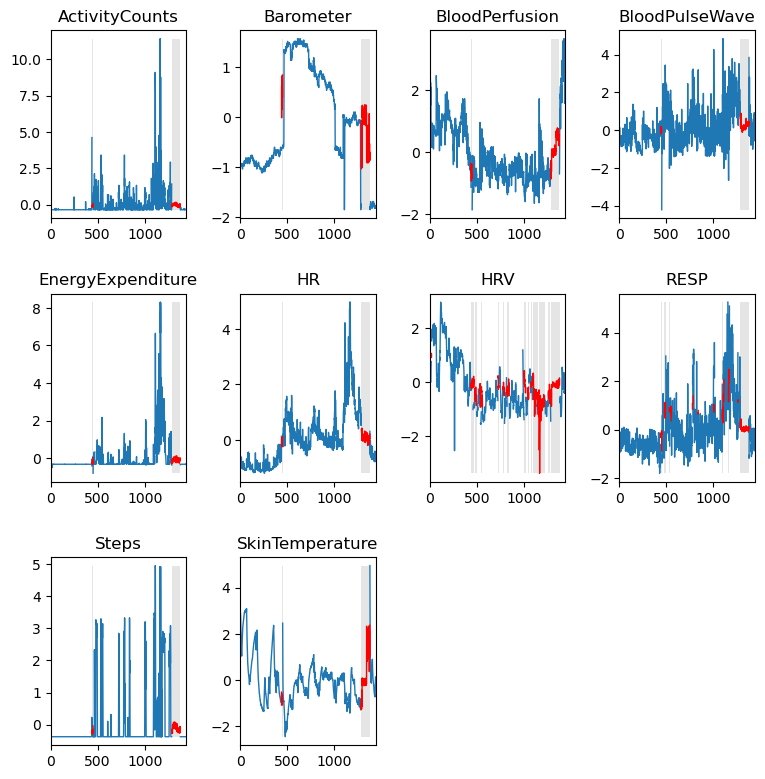

In [22]:
with torch.no_grad():
    sequence_length = model.max_len

    full_day = pd.DataFrame(test_data[0]).copy()
    mask = masker(full_day, lm=lm, masking_ratio=r)
    mask[mask == 1] = 0 # we don't mask additional segments during testing

    # reshape
    full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
    mask = mask.transpose()

    # split day into batches
    n_batches = full_day.shape[0] // sequence_length
    batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
    mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

    # mask missing data
    y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
    batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
    batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
    X = batch

    # predict
    y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

    # put back into cpu
    y_true = y_true.to('cpu')
    y_pred = y_pred.to('cpu')

    # concatenate batches into full day sequence
    y = y_true[0, :, :].numpy()
    for i in range(1, y_true.shape[0]):
        y = np.concatenate((y, y_true[i, :, :].numpy()), axis=0)
    y = y.transpose()

    yp = y_pred[0, :, :].detach().numpy()
    for i in range(1, y_pred.shape[0]):
        yp = np.concatenate((yp, y_pred[i, :, :].detach().numpy()), axis=0)
    yp = yp.transpose()

    m = mask[0, :, :]
    for i in range(1, mask.shape[0]):
        m = np.concatenate((m, mask[i, :, :]), axis=0)
    m = m.transpose()

    # visualize mask
    if show_mask:
        visualize_mask(m, '?')

    # plot imputation
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)

    if prediction_only:
        for i, variable in enumerate(VARIABLES):
            mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
            time_series_imputed = yp[i, :]
            if not full_prediction:
                time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

            plt.subplot(3, 4, i+1)
            if show_mask_plot:
                y_min, y_max = np.nanmin(time_series_imputed), np.nanmax(time_series_imputed)
                masked = mask_variable != 0
                # build continuous masking sequences for plot
                seq = []
                for j in range(len(masked)):
                    if masked[j] and j != (len(masked) - 1): # True means datapoint is masked
                        seq.append(j)
                    else:
                        if len(seq) != 0:
                            # plot background
                            plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                            seq = []
            plt.title(variable)
            plt.plot(time_series_imputed, color='red', linewidth=1)
            plt.xlim([0, 1440])
            plt.plot()
    else:
        for i, variable in enumerate(VARIABLES):
            mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
            time_series = y[i, :]
            time_series_imputed = yp[i, :]
            if not full_prediction:
                time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

            plt.subplot(3, 4, i+1)
            if show_mask_plot:
                y_min, y_max = min(np.nanmin(time_series), np.nanmin(time_series_imputed)), \
                               max(np.nanmax(time_series), np.nanmax(time_series_imputed))
                masked = mask_variable != 0
                # build continuous masking sequences for plot
                seq = []
                for j in range(len(masked)):
                    if masked[j] and j != (len(masked) - 1): # True means datapoint is masked
                        seq.append(j)
                    else:
                        if len(seq) != 0:
                            # plot background
                            plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                            seq = []
            plt.title(variable)
            plt.plot(time_series, linewidth=1)
            plt.plot(time_series_imputed, color='red', linewidth=1)
            plt.xlim([0, 1440])
            plt.plot()

Get prediction on test set

In [23]:
n_days = len(test_data)

# build masks
mask_shape = test_data[0].shape
masks = np.zeros((n_days, *mask_shape))
for day in range(n_days):
    masks[day] = masker(pd.DataFrame(test_data[day]), lm=lm, masking_ratio=r)

# score each imputation method
y_preds = np.array([])
y_trues = np.array([])
for day in range(n_days):
    data_day = pd.DataFrame(test_data[day]) # data for current day
    mask = masks[day] # mask for current day (all imputation methods use same masks)

    # impute masked data
    masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
    data_imputed = pd.DataFrame(masked_prediction(model, masked_data, device))

    # calculate error
    real_data = data_day.to_numpy()[mask == 1.0]
    imputed_data = data_imputed.to_numpy()[mask == 1.0]

    # save
    y_preds = np.concatenate([y_preds, imputed_data], axis=None)
    y_trues = np.concatenate([y_trues, real_data], axis=None)

Calculate metrics

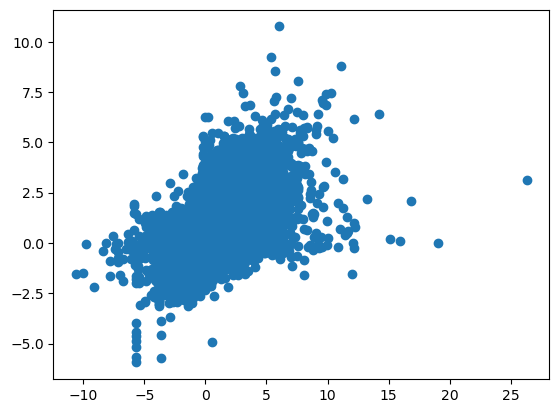

In [49]:
plt.scatter(x=y_trues, y=y_preds)

In [98]:
def test_imputation_methods(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {}
    for imputation_method in imputation_methods:
        y_preds = np.array([])
        y_trues = np.array([])
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            real_data = data_day.to_numpy()[mask == 1.0]
            imputed_data = data_imputed.to_numpy()[mask == 1.0]

            # save
            y_preds = np.concatenate([y_preds, imputed_data], axis=None)
            y_trues = np.concatenate([y_trues, real_data], axis=None)

        mae_ = mae(y_trues, y_preds)
        mre_ = mre(y_trues, y_preds)
        rmse_ = rmse(y_trues, y_preds)
        pearson_corr_ = pearson_corr(y_trues, y_preds)
        spearman_corr_ = spearman_corr(y_trues, y_preds)

        scores[imputation_method] = (mae_, mre_, rmse_, pearson_corr_, spearman_corr_)

    return sorted(scores.items(), key=lambda x: x[1][0]) # sort by MAE

In [24]:
temp = test_imputation_methods([pd.DataFrame(dat) for dat in test_data],
                        lm=lm,
                        masking_ratio=r,
                        model=model,
                        device=device)
temp

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))


[('transformer',
  (0.4961963561071316,
   2.7711579704422253,
   0.7523486415743885,
   0.6493325228312372,
   0.6424132093395257)),
 ('linear',
  (0.5045137419825719,
   4.435150628976576,
   0.9518256768168594,
   0.5133278732273454,
   0.6326858213198034)),
 ('nearest',
  (0.5407334587429998,
   4.8601434496356015,
   1.0701576114316385,
   0.46988898502638154,
   0.6118215255533819)),
 ('spline',
  (0.6655940436919059,
   3.636463357133992,
   1.207746355010901,
   0.20474447303464777,
   0.4192760759849444)),
 ('median',
  (0.6709049305811943,
   2.0321025971840094,
   1.0544527595144564,
   -0.10089533250495955,
   -0.028792905563930955)),
 ('mean',
  (0.72715394800916,
   1.402758149205084,
   1.0186417564196426,
   -0.2501272142999805,
   -0.2785699662675492)),
 ('mode',
  (0.9488824914778808,
   6.666668294002066,
   1.5088604570123174,
   -0.022184268416037017,
   0.007081106807740739)),
 ('quadratic',
  (151.1222604655906,
   598.3768087066936,
   3554.7936968826157,
   0.0

In [189]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods([pd.DataFrame(dat) for dat in test_data],
                                       lm=lm,
                                       masking_ratio=r,
                                       model=model,
                                       device=device)
    except ValueError:
        continue
    if np.any(np.isnan(np.array([element[1] for element in temp]).ravel())):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\4210325104.py:12: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\4210325104.py:12: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\4210325104.py:12: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\4210325104.py:12: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\4210325104.py:12: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\AppData\Local\Temp\ipyk

In [190]:
scores[0]

[('transformer',
  (0.5027559184138367,
   2.9267091016040627,
   0.7639908642925128,
   0.6554870199111276,
   0.6441601667224708)),
 ('linear',
  (0.5092038721983415,
   3.390352229735701,
   0.9467440428757425,
   0.5253043624507389,
   0.6347044159751988)),
 ('nearest',
  (0.5424183614835765,
   4.1079234341344675,
   1.0453325331042909,
   0.4878793165991233,
   0.6169289207799331)),
 ('spline',
  (0.6478605423324241,
   3.7320729662755916,
   0.9782836396298882,
   0.33000385486041844,
   0.42819655267679657)),
 ('median',
  (0.6773166431098695,
   2.133489316299386,
   1.0719709328099059,
   -0.1071679974158588,
   -0.033548290511484745)),
 ('mean',
  (0.7391633826433877,
   1.4257864886407414,
   1.043301910273106,
   -0.2556354320727843,
   -0.28171611290106124)),
 ('mode',
  (0.9369706542788099,
   6.772641061810797,
   1.4914799427956407,
   -0.010876433359134886,
   0.0204427779121899)),
 ('quadratic',
  (85.00382212215841,
   469.3429520116557,
   1910.7105840350425,
   -0

In [191]:
dictify = lambda x: [{vals[0]: vals[1] for vals in score} for score in x]
scores = dictify(scores)

In [192]:
scores

[{'transformer': (0.5027559184138367,
   2.9267091016040627,
   0.7639908642925128,
   0.6554870199111276,
   0.6441601667224708),
  'linear': (0.5092038721983415,
   3.390352229735701,
   0.9467440428757425,
   0.5253043624507389,
   0.6347044159751988),
  'nearest': (0.5424183614835765,
   4.1079234341344675,
   1.0453325331042909,
   0.4878793165991233,
   0.6169289207799331),
  'spline': (0.6478605423324241,
   3.7320729662755916,
   0.9782836396298882,
   0.33000385486041844,
   0.42819655267679657),
  'median': (0.6773166431098695,
   2.133489316299386,
   1.0719709328099059,
   -0.1071679974158588,
   -0.033548290511484745),
  'mean': (0.7391633826433877,
   1.4257864886407414,
   1.043301910273106,
   -0.2556354320727843,
   -0.28171611290106124),
  'mode': (0.9369706542788099,
   6.772641061810797,
   1.4914799427956407,
   -0.010876433359134886,
   0.0204427779121899),
  'quadratic': (85.00382212215841,
   469.3429520116557,
   1910.7105840350425,
   -0.0007529549535999335,
 

In [196]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
rows = []
for imputation_method in imputation_methods:
    meanify = lambda x: np.round(np.mean(x), ROUNDING)
    stdify = lambda x: np.round(np.std(x), ROUNDING)

    n_metrics = len(list(scores[0].values())[0])

    means = [meanify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]
    stds = [stdify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]

    rows.append([str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)])

table = pd.DataFrame(rows)
table.columns = ['MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
table.index = [imputation_method.capitalize() for imputation_method in imputation_methods]

In [197]:
# make smallest bold
for col in range(len(table.columns)):
    if col in (3, 4): # correlation: higher is better
        index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
    else:
        index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
    entry = table.iloc[index_best, col]
    entry = 'BOLD{' + entry + '}'
    table.iloc[index_best, col] = entry

In [ ]:
# TODO: sort by MAE!!

In [198]:
df = table
caption = f'-Imputation metrics (n=100)'
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption=caption,
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
)

\begin{table}[H]
\centering
\caption{-Imputation metrics (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                  MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Transformer} &  \textbf{0.495 ± 0.004} &        3.177 ± 0.998 &  \textbf{0.759 ± 0.007} &  \textbf{0.649 ± 0.006} &      \textbf{0.643 ± 0.005} \\
\textbf{Linear     } &        0.511 ± 0.009 &        4.786 ± 1.592 &        0.956 ± 0.027 &        0.509 ± 0.017 &             0.625 ± 0.01 \\
\textbf{Nearest    } &         0.548 ± 0.01 &        5.465 ± 1.845 &        1.062 ± 0.034 &         0.47 ± 0.017 &            0.606 ± 0.009 \\
\textbf{Spline     } &        0.712 ± 0.236 &        4.106 ± 1.362 &       6.659 ± 34.005 &        0.218 ± 0.101 &             0.415 ± 0.01 \\
\textbf{Median     } &        0.668 ± 0.007 &        2.177 ± 0.315 &         1.059 ± 0.01 &       -0.095 ± 0.011 &           -0.019 ± 0.012 \\
\textbf{Mean       } &        0.729 ± 0.

C:\Users\jjung\AppData\Local\Temp\ipykernel_15312\2166625206.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(
